<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Decision Trees
 
_Author: Adam Jones, PhD (San Francisco)_
 
---

Adapted from numerous sources, including: 
- [*An Introduction to Statistical Learning*](http://www-bcf.usc.edu/~gareth/ISL/) - Chapter 8



>This notebook will rely on Numpy, Matplotlib, and GraphViz.*
>
>\* For 'simple' installation: `$ pip install graphviz` 
>
>    [Else, try `$ brew install graphviz` (for mac)]
>
>For more info, see: https://pypi.org/project/graphviz/


<a id="learning-objectives"></a>
## Learning Objectives

- Identify the types of problems a neural network is likely to succeed at.
- Explain the similarities/differences between real and artificial neurons.
- Define the working components of a basic, feed-forward neural network.
- Determine how to apply neural networks to the prediction problem of your choosing.

### Lesson Guide
- [Where Are We Now?](#where-are-we-now)
- [Recursion Example](#recursion)
- [Intuition Behind Decision Trees](#intuition)
    - [Why Should I Use A Decision Tree?](#why)
    - [Why Shouldn't I Use A Decision Tree?](#why-not)
- [How Does It Work?](#how)
    - [An Example](#example)
- [Ensembling Methods](#ensemble)
	- [Bagging](#bagging)
	- [Random Forests](#forests)
	- [Boosting](#boosting)
- [Lesson Review](#topic-review)

In [1]:
# Import toolkits
import matplotlib as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import model_selection
import pandas as pd

%matplotlib inline

In [2]:
## Import dataset
iris = load_iris()
test_idx = [0,50,100]

<a id="where-are-we-now"></a>
## Where Are We Now?

<img src='../assets/ml_algo_map.png' style="float: center; height: 500px">
Source: [machinelearningmastery.com](http://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/)

<a id="recursion"></a>
## Recursion Example

<img src='https://imgs.xkcd.com/comics/fixing_problems.png' style="float: center; height: 250px">
Image source: [xkcd.com](https://imgs.xkcd.com/comics/fixing_problems.png)

The most common example people use to describe [recursion](https://en.wikipedia.org/wiki/Recursion) involves the [factorial function](https://en.wikipedia.org/wiki/Factorial). 

$$5! = 5*4*3*2*1 = 120$$

Imagine struggling to create a custom function to do this with any positive number. As we can see below, we can implement the factorial in Python easily and elegantly using recursion.

In [3]:
def factorial(n):
    #print(n)
    if n == 1:
        return 1
    else:
        return n * factorial(n-1)
    
factorial(5)

120

In general, recursion can be pretty opaque. But, we can get a clearer picture of what's happening inside our function from the example below.

In [4]:
factorial(4)                   # = 24
4 * factorial(3)               # = 24
4 * 3 * factorial(2)           # = 24
4 * 3 * 2 * factorial(1)       # = 24
4 * 3 * 2 * 1                  # = 24
4 * 3 * 2                      # = 24
4 * 6                          # = 24
24                             # = 24

24

**Pros:**
- Recursive functions make the code look neat and clean.
- A complex task can be performed more elegantly by breaking it down into more manageable parts using recursion.

**Cons:**
- Following the logic behind recursion can be challenging. As a result, recursive functions are often hard to debug.
- Recursive calls can be computationally expensive (inefficient) as they can take up a lot of space in memory.

<a id="intuition"></a>
## Intuition Behind Decision Trees

**Objective:** Understand the specific function of the decision tree model.

We've all been exposed to tree diagrams before, since they are used widely as a tool for representing potentially complex, decision-like processes.

<img src='https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg' style="float: center; height: 500px">
Image source: [nyt.com](https://static01.nyt.com/images/2008/04/16/us/0416-nat-subOBAMA.jpg)

Decision trees are like the game “20 questions”-

- They make decision by answering a series of questions, most often binary questions (yes or no).

- We want the smallest set of questions to get to the right answer.

- Each questions should reduce the search space as much as possible.


<img src='../assets/dec_tree_ex_simple.png' style="float: center; height: 300px">

In this notebook, we'll see how we can use _tree-based methods_ for regression and classification, by applying it to problems similar to those we've previously used linear methods to solve. As with other models, decision trees are just another way of _stratifying_ or _segmenting_ a given predictor space into 'meaningful' (_hopefully_) groups.

<a id='why'></a>

### Why Should I Use A Decision Tree?

**Non-linearity**

When dealing with _non-linear_ data (and we usually are), non-linear decision trees models can provide a limited advantage over logistic regression.

> A '_linear model_' is one in which a change in an input variable has a constant change on the output variable.
><img src='../assets/non-linearity.png' style="float: center; height: 175px">
>Image source: [erinshellman.github](http://erinshellman.github.io/data-mining-starter-kit)

Trees automatically contain interaction of features, and so are capable of more complex representations than is possible with linear models alone.

**Interpretability**

The real benefit of decision tree models are their *interpretability*. They elegantly provide intuitive insights into the decision-making process of a given model.
- As we've seen, neural networks, SVM’s, etc. ≈ black box

This makes them very useful for **feature selection***, which can be have a great impact on the accuracy and efficiency of your model.

>"Feature selection" is the process of determining the best set of features to include in our model. The 'best' features are the ones that create the greatest segregation in the data, in terms of the true label of each observation.

They helps us ask: “Which of my features are the most helpful in making predictions about my target variable?”

**Bonus**: It's also included in most ML libraries (including scikit-learn).

<a id='why-not'></a>

### Why *Shouldn't* I Use A Decision Tree?

**Braun (or lack-of)**

As useful as tree-based methods are for _interpretation_, they typically are considered 'weak model's and are **not competitive*** with the best supervised learning approaches available today.
*See [#ensemble] for some solutions to this problem.

**Over-fitting**

Decision trees tend to be weak models because they can easily memorize or overfit to a dataset.
- The algorithm will always find _some_ solution

<img src='../assets/over-fit.png' style="float: center; height: 300px">

A model is overfit when it memorizes or bends to a few specific data points rather than picking up general trends in the data.

An unconstrained decision tree can learn an extreme tree (e.g. one feature for each word in a news article) -- see example below.

<img src='./practice/tree.png' style="float: center; height: 300px">

Fortunately, we can limit our decision trees using 'pruning' methods, which are described in the next section.

<a id='how'></a>

## How Does It Work?

**Objective:** Learn the basic components of the tree-based model and how they are generated.

Perhaps not surprisingly, trees are data structures that are made up of '*leaves*' and '*branches*'.

- The point at which each branch splits is called a '*node*'. Typically, each node has two or more branches that connect it to its '*children*' (see figure below).

- Each child is another node in the tree and contains its own subtree (meaning many nodes are simultaneously parent and child nodes).

- Nodes without any children (terminal nodes) are known as 'leaves', while the 'branches' correspond to the specific set of rules used by a particular tree to segment the predictor space.

<img src='../assets/tree_nodes.png' style="float: center; height: 300px">

*Note*: The next question is always dependent on the last.

Effectively, a decision tree contains a question at every node. This is where recursion comes in handy...

- **Step 1**: Evaluate question, depending on answer, proceed down the left or right branch of the tree.
- **Step 2**: If we don’t have any more questions (at the leaf nodes), make a prediction*, else repeat Step 1.

*A 'prediction', in this case, is just the mean of the response values for the training observations in a given leaf node.

**Imagine** you wanted to design a model to **categorize** text documents into 'news about the weather' or 'not news about the weather'.
- What questions might we want to ask to make this prediction accurately?
- How many questions should we ask?

> **For example**, we might ask:  
>    Does it mentions the word 'precipitation'?  
>    If yes, then we predict 'yes'. If not we ask if it mentions 'temperature', etc.

But this works for **regression**, too. We could also imagine designing a model to predict a given baseball player's salary.
    
> In this case, we might ask:  
>    How many hits has the player has this year? Using some cut-off threshold, we decide whether to go left or right from there.  
>    Subsequently, we ask how many years has the player been on the team, etc.

<img src='../assets/hitters.png' style="float: center; height: 500px">
Image source: [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)

Each questions in intended to increase the '*purity*' of the data segments as much as possible.
- We can use a variety of metrics to quantify the purity of the separation of groups including: Classification error, Entropy, or the Gini Coefficient.
- Using one of these, the model will choose the question that gives us the best change in our purity measure at each step.
- This is done *recursively* for each new set of two groups until we reach a stopping point.

As mentioned previously, an unconstrained decision tree can become **overfit** very easily. This can lead to poor test set performance as a result of being too complex.

Although a smaller tree (with fewer splits) might increase the bias cost, they can also lower the variance and provide better interpretations overall.

Fortunately, we can limit the size of our decision trees using a few simple '*pruning*' methods:
- Limiting the number of questions (nodes) a tree can have.
- Limiting the number of samples in the leaf nodes.

We'll see how they are employed in today's lab.

<a id='example'></a>

### An Example

Decision trees can be applied to both regression and classification problems, but we'll use a simple and familiar dataset for this notebook: the iris dataset.

In [5]:
## Split training/test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(iris.data, iris.target, random_state=7)

In [6]:
column_names = iris.feature_names

In [7]:
# Tree instantiation
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
# Evaluate model
clf.score(X_test, y_test)

0.8947368421052632

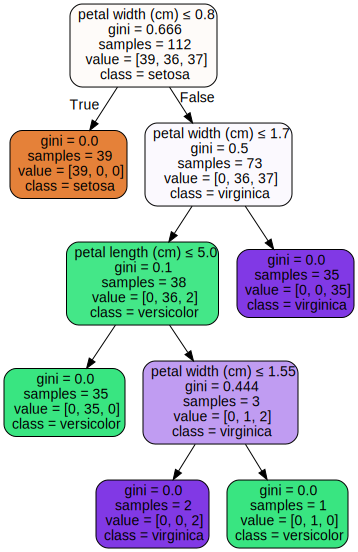

In [9]:
## Visualize decision tree
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)

graphviz.Source(dot_data) 

In [10]:
# Create random index of element in training data
rand_select = np.random.randint(0,len(X_train))

# Let's use the tree to make some predictions
print(dict(zip(iris.feature_names, X_train[rand_select])))

{'sepal length (cm)': 5.0, 'sepal width (cm)': 3.0, 'petal length (cm)': 1.6, 'petal width (cm)': 0.2}


In [11]:
# Let's double-check our predictions to see if they were right.
print(iris.target_names[y_train[rand_select]])

setosa


<a id='ensemble'></a>

## Ensembling Methods

In statistics and machine learning, '*ensemble methods*' use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

'*Bagging*', '*random forests*', and '*boosting*' each involve producing multiple trees which are then combined to yield a single consensus prediction. We'll see that combining a large number of trees can often result in dramatic improvements in prediction accuracy, at the expense of some loss in interpretation.

<a id='bagging'></a>

### Bagging

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping) is a very common statistical technique that allows us to improve on certain statistical-modeling methods such as the decision tree.

We've already learned that trees can suffer from high variance. Bootstrap aggregation, or '*bagging*', is a general-purpose procedure for reducing the variance of a statistical model, which happens to be particularly useful and frequently used in the context of decision trees

This method simply leverages the fact that *averaging a set of observations reduces variance*. Logically, then, one way to reduce variance (and increase prediction accuracy) is to take many, repeated training sets from the population, build a separate prediction model using each training set, and average the resulting predictions.

Obviously, this isn't practical because we don't usually have access to multiple training sets from the population. Fortunately, we can bootstrap, by taking repeated samples from the single training data set (*with replacement*). This is called '*bagging*'.

<a id='forests'></a>

### Random Forests

<img src='https://dsc-spidal.github.io/harp/img/4-5-1.png' style="float: center; height: 275px">

Image source: [dsc-spidal.github](https://dsc-spidal.github.io/harp/img/4-5-1.png)

Random forests provide an improvement over bagged trees in the form of a small tweak that makes the aggregated trees less correlated with each other. Just like in bagging, we build some number of decision trees on bootstrapped training samples. But here, each time a split is considered when building a tree, a random sample of
$m$ predictors is chosen as split candidates, rather than the full set of $p$ predictors.

As a result, at each split in the tree, the algorithm is not even allowed to consider a majority of the available
predictors, when building the random forest. Hence the predictions from the random forest trees will be less correlated with each other, than the predictions from the bagged trees.

#### Random Forest Algorithm  

1. Take a bootstrap sample of the dataset   

2. Train a decision tree on the bootstrap sample

    - For each split/feature selection, only evaluate a limited number of features to find the best one

3. Repeat this for N trees  

Random forest models are one of the most widespread classifiers used.

#### Advantages
- Easy to tune
- Built-in protection against overfitting
- Non-linear
- Built-in interaction effects

#### Disadvantages
- Slow
- Black-box
- No “coefficients” (harder to explain)


<a id="topic-review"></a>
## Lesson Review
---

- We learned about the use of recursion in Python.
- We saw how decision trees are built by recursively splitting the data.
- We saw that trees can be displayed graphically, and are easily interpreted even bya non-expert (as long as they are small).
- We learned about the application of decision tree models to both classification and regression problems.
- We saw the limitations of decision tree models, particularly their tendency to become overfit, and learned about 'pruning' methods available to resolve this.
- We previewed some of the 'ensembling methods' available to overcome the high-variability inherent in decision tree models.

**Any further questions?**